### Torchtext Covulutinal Neural Nets (CNN) (Conv1d)

In this notebook we are going to create a modl that will do simple binary classification using the `IMDB` dataset. From the previous notebooks we have been looking on how we can load our own dataset from files. In this notebookwe are going to use the `torchtext.dataset` to load available datasets from `torchtext`. The text classification datasets are listed in the [docs](https://pytorch.org/text/stable/datasets.html#imdb).

> This notebook will look similar to the previous one we are just going to change few things.


###  Installation of Packages

In the following code cell we are going to install the packages that we are going to use in this notebook which are `helperfns`, `torchdata` and `emoji`. The `emoji` package allows us to get emoji text and we will use it later on in this notebook. The `helperfns` package allows us to get some machine learning helper function which we are also going to use in this notebook as well.

In [1]:
!pip install helperfns -q

In [2]:
!pip install emoji -q

     |████████████████████████████████| 197 kB 34.6 MB/s 


In [3]:
!pip install torchdata -q

     |████████████████████████████████| 4.4 MB 25.1 MB/s 
     |████████████████████████████████| 140 kB 66.1 MB/s 
     |████████████████████████████████| 127 kB 63.2 MB/s 


### Imports 

In the following code cell we are going to import all the packages that are going to be used in this notebook.

In [4]:
import time
import emoji
import torch
import os
import random
import torchtext

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from google.colab import drive
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns import tables, visualization, utils

from torchtext.datasets import IMDB

import torch.nn.functional as F
import numpy as np

torchtext.__version__, torch.__version__

('0.13.1', '1.12.1+cu113')

### Device
In the following code cell we are going to create a device variable and utilize the `cuda` GPU if available in this notebook.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Seed

In the following  code cell we are going to define the seed for reproducivity in this notebook.

In [6]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Loading IMDB dataset
In the following code cell we are going to load the `IMDB` dataset.

In [7]:
train_iter, test_iter = IMDB(root=".data", split=('train', "test"))

### Getting text and labels

In the following code cell we are then going to get the features and labels for our sets.

In [21]:
train_text = []
train_labels = []

for (labels, line) in train_iter:
  train_text.append(line)
  train_labels.append(labels)

test_text = []
test_labels = []

for (labels, texts) in test_iter:
  test_text.append(texts)
  test_labels.append(labels)

In [23]:
assert len(test_text) == len(test_labels)
assert len(train_text) == len(train_labels)

### Checking examples.

In [24]:
train_text[:2]

['Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn\'t really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I\'d have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.',
 "Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Br

In [25]:
train_labels[:2]

['pos', 'pos']

In [26]:
test_text[:2]

["Previous reviewer Claudio Carvalho gave a much better recap of the film's plot details than I could. What I recall mostly is that it was just so beautiful, in every sense - emotionally, visually, editorially - just gorgeous.<br /><br />If you like movies that are wonderful to look at, and also have emotional content to which that beauty is relevant, I think you will be glad to have seen this extraordinary and unusual work of art.<br /><br />On a scale of 1 to 10, I'd give it about an 8.75. The only reason I shy away from 9 is that it is a mood piece. If you are in the mood for a really artistic, very romantic film, then it's a 10. I definitely think it's a must-see, but none of us can be in that mood all the time, so, overall, 8.75.",
 'CONTAINS "SPOILER" INFORMATION. Watch this director\'s other film, "Earth", at some point. It\'s a better film, but this one isn\'t bad just different.<br /><br />A rare feminist point of view from an Indian filmmaker. Tradition, rituals, duty, secret

In [27]:
test_labels[:2]

['pos', 'pos']

#### Counting examples
In the following code cell we are going to count how many examples do we have in each set and visualize them in a tabular format.

In [28]:
columns = ["Set", "Example(s)"]
examples = [
    ['training', len(train_text)],
    ['testing', len(test_text)],
    ['total', len(train_text) +  len(test_text)],
]
tables.tabulate_data(columns, examples, "Exmples")

+-----------------------+
|        Exmples        |
+----------+------------+
|   Set    | Example(s) |
+----------+------------+
| training |      25000 |
| testing  |      25000 |
| total    |      50000 |
+----------+------------+


### Text Preprocessing
In our text processing pipeline we need to do the following step:

1. tokenize text 
- this is the process of converting a sentence or text into senquence of word. For this we are going to use a pre-trained model from `spacy` language model. You can read more about other tokenizers that you can use at [pytorch.org](https://pytorch.org/text/stable/data_utils.html).

2. vocabulary
* We will to create a vocabulary based on our text. A vocabulary is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.


#### Tokenizer

In the following code cell we are going to geta a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model.

In [29]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:106: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead'


['This', 'is', 'a', 'boy', '.']

### Text Cleaning
In this notebook i will not focus much about text cleaning, but to improve the model accuracy we need to do text cleaning.

#### Vocabulary
In the following code cell we are going to create a vocabulary object from  `torchtext`. This vocabulary takes in an `ordered_dict` of words to their count. So we are going to use the `Counter` module from collections to generate these counts from our train features.

We are going to specify the `min_freq` to `5` meaning that the words that does not appear at least 5 times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object. 

In [31]:
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line.lower()))
vocabulary = vocab.vocab(counter, min_freq=5, specials=('<unk>', '<sos>', '<eos>', '<pad>'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping.

In [32]:
stoi = vocabulary.get_stoi()

### Text Pipeline

After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes over. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay `stoi` will be habin an unkown (`<unk>`) index.

In [33]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['<unk>']
    values.append(v)
  return values

### Label pipeline

 We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation. Which looks as follows:

```
{'pos': 1, 'neg': 0}
```
The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [34]:
labels_dict = {'pos': 1, 'neg': 0}
labels_dict

{'pos': 1, 'neg': 0}

In [35]:
label_pipeline = lambda x: labels_dict[x]

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.100d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `100` dimension. If you want to see which other vectors you can use in torchtext you can check [pytorch.org](https://pytorch.org/text/stable/vocab.html#glove). We are going to load these vectors as follows:

In [36]:
EMBEDDING_DIM = 100

glove_vectors = vocab.GloVe('6B', dim=EMBEDDING_DIM)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 24672.97it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [37]:
VOCAB_SIZE = len(stoi)

EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])

for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `good`.

In [38]:
EMBEDDING_MATRIX[stoi['good']]

tensor([-0.0308,  0.1199,  0.5391, -0.4370, -0.7394, -0.1534,  0.0811, -0.3856,
        -0.6880, -0.4163, -0.1318, -0.2492,  0.4410,  0.0859,  0.2087, -0.0636,
         0.0622, -0.0512, -0.1340,  1.1418,  0.0365,  0.4903, -0.2457, -0.4120,
         0.1235,  0.4134, -0.4840, -0.5424, -0.2779, -0.2601, -0.3848,  0.7866,
         0.1023, -0.2071,  0.4075,  0.3203, -0.5105,  0.4836, -0.0099, -0.3868,
         0.0350, -0.1670,  0.4237, -0.5416, -0.3032, -0.3698,  0.0828, -0.5254,
        -0.0645, -1.3980, -0.1487, -0.3533, -0.1118,  1.0912,  0.0959, -2.8129,
         0.4524,  0.4621,  1.6012, -0.2084, -0.2738,  0.7120, -1.0754, -0.0470,
         0.6748, -0.0658,  0.7582,  0.3941,  0.1551, -0.6472,  0.3280, -0.0317,
         0.5290, -0.4389,  0.6740,  0.4214, -0.1198, -0.2178, -0.2976, -0.1351,
         0.5990,  0.4653, -0.5826, -0.0232, -1.5442,  0.0190, -0.0159,  0.0245,
        -0.5802, -0.6766, -0.0404, -0.4404,  0.0833,  0.2004, -0.7550,  0.1692,
        -0.2657, -0.5288,  0.1758,  1.06

### Creating the IMDBDataset
In the following code cell we are going to create a dataset class called `IMDBDataset`. This dataset will takes in the `labels` and the `text` of a set.

In [39]:
class IMDBDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(IMDBDataset, self).__init__()
    self.labels = labels
    self.text = text
      
  def __getitem__(self, index):
    return self.labels[index], self.text[index]
  
  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function acually takes in a batch and does the preprocessing of the text and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

`tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and pad and truncate the sequence to the same length and returns `labels` and `features`.

In [58]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  return torch.FloatTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `EmotionDataset` class.

In [59]:
train_dataset = IMDBDataset(train_labels, train_text)
test_dataset = IMDBDataset(test_labels, test_text)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [60]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

### Checking a single Batch Data

In [61]:
lbl, txt = iter(train_loader).next()

Labels in the first batch.

In [62]:
lbl

tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 0.])

The first sentence in the batch.

In [63]:
txt[0]

tensor([  137,    38,   690,    18,  1484,    13,    38,  1868,    22,    10,
         3131,   126,    45,    38,  1484,    22,   152,  3436,   920,   405,
           65,    85,  1938,    38,  1261,   479,     7,   520,  1771,    25,
           70,     5,   453,   106,   314,   506,     7,    38,  6500,    85,
           69,   919,    13,   431,  1261,   766,   283,   116, 10158,   287,
           45,    38, 13902, 16827,     0,  3436,  1785,    25,    70,  1652,
          419,    10,    85,   116,    48,    10,  7126, 13117,  2167,   284,
           10,   280,    25,    54,   901,    42,   407,    65,   284,    10,
          552,   624,    70,   419,    92,   931, 15063,   468,   159,   405,
           97,    70,   126,  4710,   213,   567,   504,    10,  2277,    57],
       dtype=torch.int32)

### Model Creation

Now that we have our loaders we can now create a model. The model that we are going to create is called `IMDBModel`. In the following code cell we are going to create our `CNN` model. Note that this code for creating a model was taken from [this notebook](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/04_CNN_Sentiment_Analyisis.ipynb). We are just going to modify it a little bit.

In [64]:
class IMDBModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
            dropout, pad_idx):
    super(IMDBModel, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv1d(
                in_channels = embedding_dim, 
                out_channels = n_filters, 
                kernel_size = fs
              ) for fs in filter_sizes
        ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_dim)
    )
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, text):
    embedded = self.embedding(text)  
    embedded = embedded.permute(0, 2, 1)
    conved = [F.relu(conv(embedded)) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)

### Model Instance

In the following code cell we are going to create a model instance.

In [65]:
INPUT_DIM = len(stoi) 
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = stoi['<pad>'] 
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]

imdb_model = IMDBModel(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)
imdb_model

IMDBModel(
  (embedding): Sequential(
    (0): Embedding(31264, 100, padding_idx=3)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
      (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [66]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(imdb_model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 3,247,001
Total tainable parameters: 3,247,001


### Loading Embedding Vectors

In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `emotions_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [67]:
imdb_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5205,  0.0264, -0.5739,  ...,  0.4433, -0.4550, -0.0435],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1073, -0.3334, -0.8606,  ...,  0.5667,  0.4736,  0.1538]],
       device='cuda:0')

### Optimizer and Criterion

In the following code cell we are going to define the optimizer and criterion. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `BCEWithLogitsLoss()` function since this is a binary classification task.

In [68]:
optimizer = torch.optim.Adam(imdb_model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [69]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float() #convert into float for division 
  acc = correct.sum() / len(correct)
  return acc

### Train and Evaluate functions

In the following code cell we are going to create our `train` and `evalutate` functions:

In [70]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()

    predictions = model(X).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      predictions = model(X).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop

In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [71]:
N_EPOCHS = 10
MODEL_NAME = 'imdb-torch.pt'

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(imdb_model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(imdb_model, test_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(imdb_model.state_dict(), MODEL_NAME)
  end = time.time()
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{utils.hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],       
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
  tables.tabulate_data(columns, data, title)


+--------------------------------------------+
|     EPOCH: 01/10 saving best model...      |
+------------+-------+----------+------------+
|  CATEGORY  |  LOSS | ACCURACY |    ETA     |
+------------+-------+----------+------------+
| Training   | 0.563 |    0.701 | 0:00:37.10 |
| Validation | 0.450 |    0.789 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/10 saving best model...      |
+------------+-------+----------+------------+
|  CATEGORY  |  LOSS | ACCURACY |    ETA     |
+------------+-------+----------+------------+
| Training   | 0.405 |    0.818 | 0:00:32.21 |
| Validation | 0.411 |    0.808 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/10 saving best model...      |
+------------+-------+----------+------------+
|  CATEGORY  |  LOSS | ACCURACY |    ETA     |
+------------+-------+----------+------------+
| Training   

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [73]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
imdb_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(imdb_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tables.tabulate_data(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.399 |   81.84% |            |
+------+-------+----------+------------+


### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [72]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with <pad> = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Model Inference
In the following code cell we are going to create a function that predicts the movie review sentiment in the text that is called `predict_sentiment`.

In [80]:
def predict_sentiment(model, sentence, min_len = 5):
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence).to(device)
    probability= torch.sigmoid(model(tensor).squeeze(0)).detach().cpu().item()
    prediction = round(probability)
    probability = probability if prediction == 1 else 1 - probability
    classes = {v:k for k, v in labels_dict.items()}
    class_name = classes[prediction]
    columns_ =  ["label", 'value']
    title = "PREDICTIONS OF EMOTIONS"
    data = [
        ['text', sentence],
        ['predicted class', prediction],
        ['predicted class name', class_name],
        ['probability', round(probability, 2)]
    ]
    tables.tabulate_data(columns_, data, title)

In [81]:
# negative review
predict_sentiment(imdb_model, "this movie is boring i don't like it at all.")

+---------------------------------------------------------------------+
|                       PREDICTIONS OF EMOTIONS                       |
+----------------------+----------------------------------------------+
|        label         |                    value                     |
+----------------------+----------------------------------------------+
| text                 | this movie is boring i don't like it at all. |
| predicted class      |                                            0 |
| predicted class name |                                          neg |
| probability          |                                         0.95 |
+----------------------+----------------------------------------------+


In [82]:
# fear
predict_sentiment(imdb_model, "the best movie of all time.")

+----------------------------------------------------+
|              PREDICTIONS OF EMOTIONS               |
+----------------------+-----------------------------+
|        label         |            value            |
+----------------------+-----------------------------+
| text                 | the best movie of all time. |
| predicted class      |                           1 |
| predicted class name |                         pos |
| probability          |                        0.89 |
+----------------------+-----------------------------+


### Confusion matrix.

In the following code cell we are going to extract features and labels that we are going to use to plot our confusion matrix. We are going to use the `test` set.

In [83]:
test_features = []
test_labels = []
for (y, X) in test_loader:
  test_features.extend(X.numpy())
  test_labels.extend(y.numpy())
test_features = torch.tensor([i for i in test_features]).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [87]:
imdb_model.eval()
with torch.no_grad():
  preds = torch.sigmoid(imdb_model(test_features))
  preds = [1 if pred >=0.5 else 0 for pred in preds]

In [89]:
classes = [k for k, v in labels_dict.items()]
classes

['pos', 'neg']

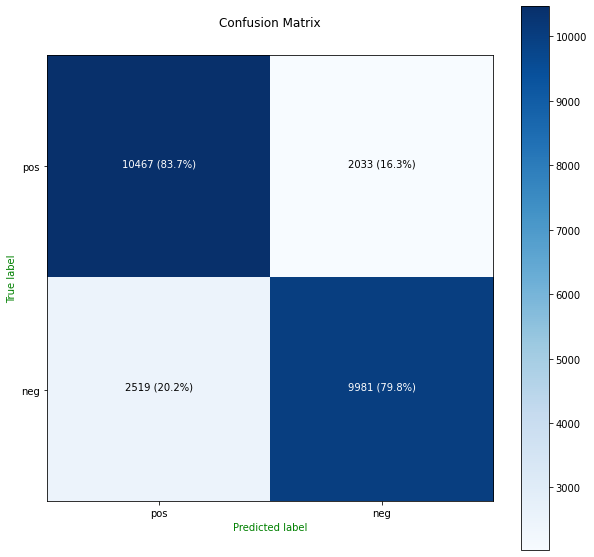

In [90]:
visualization.plot_complicated_confusion_matrix(test_labels, preds, classes, figsize=(10, 10), fontsize=10)